#0. Library, load data

In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import shap
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,recall_score,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset
import kagglehub

warnings.filterwarnings('ignore')

# loan_df = pd.read_csv('loan.csv')
# dict_df = pd.read_excel('Data_Dictionary.xlsx')

In [7]:
# Download latest version
path = kagglehub.dataset_download("abhishek14398/loan-dataset")

print("Path to dataset files:", path)

100%|██████████| 8.39M/8.39M [00:00<00:00, 9.07MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhishek14398/loan-dataset/versions/1


In [8]:
!ls $path

Data_Dictionary.xlsx  loan.csv


In [9]:
mainpath = path
data_dictionary_path =os.path.join(mainpath, 'Data_Dictionary.xlsx')
loan_path = os.path.join(mainpath, 'loan.csv')
loan_df = pd.read_csv(loan_path)
dict_df = pd.read_excel(data_dictionary_path)

#1. Data Understanding and Cleaning

In [10]:
loan_df.shape

(39717, 111)

In [11]:
loan_df.dtypes

,0
id,int64
member_id,int64
loan_amnt,int64
funded_amnt,int64
funded_amnt_inv,float64
...,...
tax_liens,float64
tot_hi_cred_lim,float64
total_bal_ex_mort,float64
total_bc_limit,float64


In [12]:
# Checking for Duplicate rows in the dataset.
print(loan_df.duplicated(subset=None,keep='first').count())

# The column used for checking is id column
duplicate_rows=loan_df[loan_df.duplicated(['id'])]
print("duplicate_rows :", duplicate_rows)

39717
duplicate_rows : Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, verification_status_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, ma

In [ ]:
# Check duplicated data
loan_df.duplicated().sum()

In [ ]:
# Delete completely empty columns
loan_df = loan_df.dropna(axis=1, how='all')

In [ ]:
# Finding number of rows through sum function which have missing values
print('Number of rows having all values as null:')
print(loan_df.isnull().all(axis=1).sum())

# Finding the number of columns through sum function which have missing values

print('Number of columns having all values as null:')
print(loan_df.isnull().all(axis=0).sum())

In [ ]:
# Inconsistencies data
numeric = loan_df.select_dtypes(include=np.number)
(numeric.values < 0).sum()

In [ ]:
# Loại bỏ ký hiệu % trong cột 'int_rate' và 'revol_util' để thêm vào trong phân tích
loan_df['int_rate'] = loan_df['int_rate'].str.rstrip('%').astype(float)
loan_df['revol_util'] = loan_df['revol_util'].str.rstrip('%').astype(float)

In [ ]:
loan_df['emp_length']=loan_df.emp_length.str.extract('(\d+)')
# Chuyển đổi các cột dữ liệu số thành kiểu numeric
columns1=['loan_amnt','funded_amnt','int_rate','funded_amnt_inv','installment','annual_inc','dti','emp_length','total_pymnt']
loan_df[columns1]=loan_df[columns1].apply(pd.to_numeric)

In [ ]:
# Loại bỏ giá trị 'Current' trong cột 'loan_status' do vẫn còn trong thời hạn mượn nợ
loan_df = loan_df[loan_df.loan_status != "Current"]

In [ ]:
loan_df.loan_status.value_counts()

In [ ]:
# Điền giá trị 0 cho các dòng Null trong cột 'pub_rec_bankruptcies'
loan_df['pub_rec_bankruptcies'].fillna(0, inplace = True)

In [ ]:
loan_df['pub_rec_bankruptcies'].isnull().sum()

In [ ]:
# Tính tỷ lệ giá trị thiếu cho mỗi cột
missing_values = loan_df.isnull().mean() * 100

# Xác định các cột có tỷ lệ giá trị thiếu lớn hơn 10%
cols_to_drop = missing_values[missing_values > 10].index

# Xóa các cột này khỏi DataFrame
loan_df = loan_df.drop(columns=cols_to_drop)

# Hiển thị các cột đã bị xóa
print(f"Các cột đã bị xóa: {cols_to_drop.tolist()}")

In [ ]:
# Impute missing values using IterativeImputer
imputer = IterativeImputer(random_state=100, max_iter=10)
# fit on the dataset
df2 = loan_df.select_dtypes(exclude= 'object')
imputer.fit(df2)
df_imputed = imputer.transform(df2)
df_imputed[:10]
df_imputed = pd.DataFrame(df_imputed, columns=df2.columns)
df = loan_df.drop(columns=df2.columns)
loan_df = pd.concat([df_imputed, df], axis=1)

In [ ]:
# Boxplot outliers
numeric = pd.melt(numeric, var_name='Column', value_name='Value')
sns.boxplot(data=numeric, x='Column', y='Value')
plt.title("Boxplot for Numerical Column before Outlier Treatment")
plt.xticks(rotation=90)
plt.show()

In [ ]:
loan_df.describe()

In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows where the value is outside the bounds
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_cleaned

In [ ]:
# Do cột 'annual_inc' có nhiều giá trị ngoại lai nên ta sẽ remove
loan_df = remove_outliers(loan_df, 'annual_inc')

#2. Feature selection & visualization

In [ ]:
numeric = pd.melt(loan_df.select_dtypes(exclude = 'object'), var_name = 'Column', value_name = 'Value')
sns.boxplot(data=numeric, x='Column', y='Value') # Use the loan_df DataFrame that includes 'Column' and 'Value'
plt.title("Boxplot for Numerical Column after Outlier Treatment")
plt.xticks(rotation=90) # Rotate x-axis labels for better readability if needed
plt.show()

In [ ]:
loan_df.describe()

In [ ]:
# Tính phần trăm dựa vào mục đích vay
(loan_df.purpose.value_counts()*100)/len(loan_df)

In [ ]:
# Do Feature Selection
unnecessary_column = ["application_type","policy_code","initial_list_status","installment","pymnt_plan"]
loan_df.drop(labels = unnecessary_column,axis = 1,inplace = True)
print(loan_df.shape)
loan_df.isnull().sum()

In [ ]:
# Bỏ các cột addr_state, grade, url vì các dữ liệu không ảnh hưởng đến việc dự đoán
columns_to_drop = ['addr_state', 'grade', 'url']
loan_df = loan_df.drop(columns=[col for col in columns_to_drop if col in loan_df.columns])

In [ ]:
numerical_features = loan_df.select_dtypes(exclude = 'object').columns
# Plot distributions
num_features = len(numerical_features)
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(loan_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# Bỏ các cột out_prncp, out_prncp_inv, chargeoff_within_12_mths, delinq_amnt, tax_liens vì các giá trị không đổi
columns_to_drop = ['out_prncp', 'out_prncp_inv', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
loan_df = loan_df.drop(columns=[col for col in columns_to_drop if col in loan_df.columns])

In [ ]:
loan_df.shape

In [ ]:
# Label Encoding for binary categorical columns
label_encoder = LabelEncoder()
binary_cols = loan_df.select_dtypes(include=['object']).columns.intersection(['term', 'sub_grade', 'home_ownership',
                                                                             'verification_status', 'issue_d',
                                                                             'purpose', 'title', 'zip_code',
                                                                             'earliest_cr_line',
                                                                             'last_pymnt_d', 'last_credit_pull_d', 'emp_title'])
for col in binary_cols:
    loan_df[col] = label_encoder.fit_transform(loan_df[col])

for col in binary_cols:
    freq_encoding = loan_df[col].value_counts().to_dict()
    loan_df[col] = loan_df[col].map(freq_encoding)

- Thay giá trị 'Fully Paid' = 1, 'Charged Off' = 0 do nếu 1 người trả nợ thì có thể tiếp tục cho mượn và ngược lại.
- Nên lấy loan_status làm cột target cho model.

In [ ]:
loan_df['loan_status'] = loan_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

In [ ]:
# Điền các giá trị trống bằng giá trị median
loan_df = loan_df.fillna(loan_df.median())

In [ ]:
# Assuming 'loan_status' is the column indicating loan acceptance/rejection
# Encode 'loan_status' if it's categorical
loan_df['loan_status'] = loan_df['loan_status'].apply(lambda x: 1 if x == 1.0 else 0)

# Calculate the correlation matrix
correlation_matrix = loan_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.show()

- Từ hình ta thấy được sự tương quan giữa các feature với nhau, các feature có sự tương quan lớn nên có loại bỏ được 1 trong 2.

In [ ]:
# Loại bỏ các cột có độ tương quan cao
columns_to_drop = ['member_id', 'funded_amnt_inv', 'total_pymnt_inv', 'issue_d']
loan_df = loan_df.drop(columns=[col for col in columns_to_drop if col in loan_df.columns])

In [ ]:
# Count different values for loan_status
loan_status_counts = loan_df['loan_status'].value_counts()

# Print the counts
print("Class Distribution of Loan Status:")
print(loan_status_counts)

# Plot the class distribution
plt.figure(figsize=(8, 6))
loan_status_counts.plot(kind='bar')
plt.title('Class Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
numerical_features = loan_df.drop(columns=['id', 'collections_12_mths_ex_med', 'acc_now_delinq']).select_dtypes(include=np.number).columns

# Plot distributions
num_features = len(numerical_features)
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(loan_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
loan_df.shape

1. **Class Distribution**:
   - Analyze the balance of accepted vs. rejected loans được thực hiện bằng cách đếm số lần xuất hiện của Fully paid và Charged off.
   - Vẽ biểu đồ cột để trực quan hóa loan_status.

2. **Feature Distributions**:
   - Vẽ các biểu đồ cột thể hiện sự phân bố dữ liệu của từng feature. Từ đó, tập trung vào các feature có mật độ phân bố trải đều, ổn định như: dti, annual_inc, total_pymnt, total_acc...

3. **Correlation Analysis**:
   - Vẽ biểu đồ nhiệt để thể hiện sự tương quan của features qua correlation matrix, loại bỏ các feature có độ tương quan lớn.

4. **Missing Values**:
   - Dựa vào phần trăm các giá trị bị thiếu để lựa chọn feature phù hợp cho mô hình.
   - Giữ lại các feature có phần trăm thiếu sót dưới 10% do các feature có ít sự liên kết với nhau.
   - Điền các giá trị thiếu bằng 2 cách:
      - Đối với numeric_features: sử dụng mô hình MICE để dự đoán.
      - Đối với categorical variables: encoding dữ liệu sau đó điền giá trị bị thiếu bằng median.

In [ ]:
# create the scaler
ss = StandardScaler()

# fit and transform the data
loan_df_scaled = ss.fit_transform(loan_df.select_dtypes(exclude= 'object'))

In [ ]:
# Assuming loan_df is your DataFrame and 'loan_status' is the target variable

# 1. Prepare the data
X = loan_df.drop(columns=['loan_status','id', 'collections_12_mths_ex_med','acc_now_delinq'])  # Features
y = loan_df['loan_status']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#II Model Development

Decision Tree

In [ ]:
# Create the Decision Tree model with class weight to minimize false positives
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

y_val_pred = dt_model.predict(X_val)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

In [ ]:
# Predict on the validation set
y_test_pred = dt_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

HyperTunning

In [ ]:
# Hàm mục tiêu
def objective(trial):
    # Tham số để tối ưu hóa
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Mô hình Decision Tree
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        class_weight='balanced'
    )

    # Tính Recall của lớp 0 với Cross-Validation
    recall_scores = cross_val_score(
        dt_model, X_train, y_train,
        cv=5, scoring=make_scorer(recall_score, pos_label=0)
    )

    # Trả về Recall trung bình
    return recall_scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')  # Tối đa hóa Recall lớp 0
study.optimize(objective, n_trials=50)  # Thử nghiệm 50 lần

# Kết quả tốt nhất
print("Best parameters:", study.best_params)
print("Best recall for class 0:", study.best_value)

In [ ]:
best_params = study.best_params
dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train)

In [ ]:
y_train_pred = dt_model.predict(X_train)
print("Train Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

In [ ]:
# Predict on the validation set
y_val_pred=dt_model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))
# Predict on the test set
y_test_pred = dt_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))


Feature Selection

In [ ]:
# Lấy trọng số của từng feature
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Hiển thị các đặc trưng quan trọng
print("Feature Importances:")
print(feature_importances.head(20))


In [ ]:
threshold =0.03
selected_features = feature_importances[feature_importances['Importance'] > threshold]
selected_features

In [ ]:
X_val_selected_dict = {}

In [ ]:
# Lấy danh sách các feature từ selected_features
selected_feature_names = selected_features['Feature'].tolist()

# Lọc X_train chỉ giữ lại các feature trong selected_feature_names
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Hiển thị các cột đã được chọn
print(X_train_selected.columns)

In [ ]:
X_val_selected_dict["decision tree"] = X_val_selected

In [ ]:
# Train the model
dt_model.fit(X_train_selected, y_train)

y_val_pred = dt_model.predict(X_val_selected)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

In [ ]:
y_test_pred = dt_model.predict(X_test_selected)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

Logistic Regression Model

In [ ]:
logistic_model = LogisticRegression(class_weight='balanced', random_state=42, penalty='l2', solver='liblinear')

logistic_model.fit(X_train, y_train)

y_val_pred = logistic_model.predict(X_val)
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

HyperTunning

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': ['balanced']
}

In [ ]:
# Tạo đối tượng LogisticRegression
model = LogisticRegression()

# Sử dụng GridSearchCV để tìm các tham số tốt nhất
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(recall_score,pos_label=0),cv=5, n_jobs=-1)

# Huấn luyện mô hình
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)

In [ ]:
# Dự đoán và đánh giá mô hình
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

In [ ]:
y_val_pred = best_model.predict(X_val)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Feature Selection

In [ ]:
weights = logistic_model.coef_[0]

# Tạo DataFrame chứa các feature và trọng số tương ứng
weights_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': weights
})

# Sắp xếp theo trọng số giảm dần
weights_df = weights_df.sort_values(by='Weight', ascending=False)

# Hiển thị các feature quan trọng
print("Feature Weights:")
print(weights_df.head(20))

In [ ]:
feature_weights = logistic_model.coef_[0]

# Chọn đặc trưng có trọng số lớn (chẳng hạn chỉ chọn những đặc trưng có trọng số > 0)
selected_features = np.abs(feature_weights) > 1e-5  # Ngưỡng có thể thay đổi

# Chọn ra X_train_selected
X_train_selected = X_train.loc[:, selected_features]

# In ra các đặc trưng được chọn
print("Selected Features:", X_train.columns[selected_features])

# In ra X_train_selected
print("X_train_selected shape:", X_train_selected.shape)

In [ ]:
X_val_selected = X_val.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

In [ ]:
X_val_selected_dict["logistic"] = X_val_selected

In [ ]:
best_model.fit(X_train_selected, y_train)

y_val_pred = best_model.predict(X_val_selected)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Pytorch

In [ ]:
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Use long type for CrossEntropyLoss
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)  # Use long type for CrossEntropyLoss

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
# Chuyển đổi dữ liệu sang GPU
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

In [ ]:
# Khởi tạo mô hình
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(y_train.unique())
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

In [ ]:

class_weights = torch.tensor([6.0, 1.0], dtype=torch.float32).to(device) # Tăng trọng số cho lớp 0 lên 6 lần so với lớp 1

# Chuyển criterion sang GPU
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Khởi tạo optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print("Recall Score: ", recall_score(y_train, model(X_train_tensor).argmax(dim=1).cpu().detach().numpy(), pos_label=0))


In [ ]:
# Đánh giá mô hình
# Dự đoán trên tập kiểm tra
model.eval()
with torch.no_grad():
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Chuyển đổi tensor thành numpy array
y_val_np = y_val_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Đánh giá mô hình
print("Confusion Matrix:")
print(confusion_matrix(y_val_np, predicted))
print("\nClassification Report:")
print(classification_report(y_val_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_val_np, predicted))
print("\nRecall Score for class 0:")
print(recall_score(y_val_np, predicted, pos_label=0))

In [ ]:
#Model Evaluation
X_test = scaler.transform(X_test)
# Predict on the test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Convert the tensors to numpy arrays
y_test_np = y_test_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, predicted))
print("\nClassification Report:")
print(classification_report(y_test_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_test_np, predicted))
print("\nROC AUC Score:")
print(roc_auc_score(y_test_np, predicted))

HyperTunning for Pytorch

In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [ ]:
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64]) #Do máy tính không đủ tài nguyên nên chỉ chọn 2 giá trị
    num_epochs = 10

    # Initialize model with hyperparameters
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    input_size = X_train.shape[1]
    num_classes = len(torch.unique(y_train_tensor))
    model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate recall for class 0
    recall_0 = recall_score(val_labels, val_preds, pos_label=0)
    return recall_0  # Optuna will maximize this metric


In [ ]:
study = optuna.create_study(direction='maximize')  # Maximize recall for class 0
study.optimize(objective, n_trials=50)  # Run 50 trials

# Output the best parameters
print("Best parameters:", study.best_params)
print("Best recall for class 0:", study.best_value)

In [ ]:
best_params = study.best_params

# Create DataLoader with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Initialize the model with the best parameters
model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    num_classes=len(torch.unique(y_train_tensor))
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Final training loop
for epoch in range(100):  # You can choose more epochs here for final training
    model.train().to(device)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print("Recall Score: ", recall_score(y_train, model(X_train_tensor).argmax(dim=1).cpu().detach().numpy(), pos_label=0))

In [ ]:
X_val_selected_dict["neural network"] = X_test_tensor

In [ ]:
#Model Evaluation
X_test = scaler.transform(X_test)
# Predict on the test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Convert the tensors to numpy arrays
y_test_np = y_test_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, predicted))
print("\nClassification Report:")
print(classification_report(y_test_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_test_np, predicted))
print("\nROC AUC Score:")
print(roc_auc_score(y_test_np, predicted))

# 4. Explainability

In [83]:
decision_tree_model = dt_model
logistic_model = best_model
neural_network_model = model

In [84]:
print(X_val_selected_dict['neural network'].shape)

torch.Size([11045, 32])


In [364]:
import matplotlib.pyplot as plt

**GLOBAL EXPLAINABILTIY**

**decision tree**

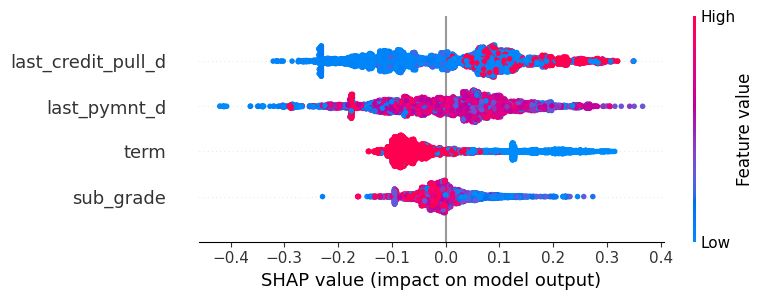

In [496]:
plt.clf()
# SHAP values for Decision Tree
explainer_dt = shap.TreeExplainer(decision_tree_model,
                                  data = X_val_selected_dict['decision tree'])

shap_values_dt = explainer_dt.shap_values(X_val_selected_dict['decision tree'])

shap.summary_plot(shap_values_dt[:,:,0],
                  X_val_selected_dict['decision tree'],
                  max_display = 10)

plt.show()
display(plt.gcf())


**"last_credit_pull-d" :** ta nhận thấy rằng tiêu chí này thường, nếu giá trị thấp thì thường sẽ củng cố cho dự đoán lớp "0" - loan rejected (giảm khả năng được chấp thuận), về mặt ý nghĩa, thuộc tính này biểu thị cho việc nếu khách hàng đã yêu cầu khoản vay gần đây (dẫn tới giá trị của thuộc tính cao), thường có xu hướng tài chính kém ổn định hơn.

**Thuộc tính "last_pymnt_d" (tháng mà người vay đã thực hiện khoản thanh toán cuối cùng cho khoản vay của họ.):** hai thuộc tính này cũng có xu hướng tương tự khi chúng thể hiện việc tình trạng nợ hoặc khả năng trả nợ chưa tốt, trong khi thời gian xa hơn (giá trị thuộc tính sẽ thấp hơn) có thể phản ảnh tình trạng tài chính ổn định hơn.

Còn đối với hai tiêu chí "term" (kỳ hạn khoản vay) và "sub_grade" (xếp hạng tính dụng con) ít có đóng góp hơn vào sự dự đoán trong việc từ chối khoản vay, nhưng nhìn chung, nếu

**Logistic model**

In [91]:
print(X_val_selected_dict['logistic'].shape)
print(X_val_selected_dict['neural network'].shape)

(5154, 29)
torch.Size([11045, 32])


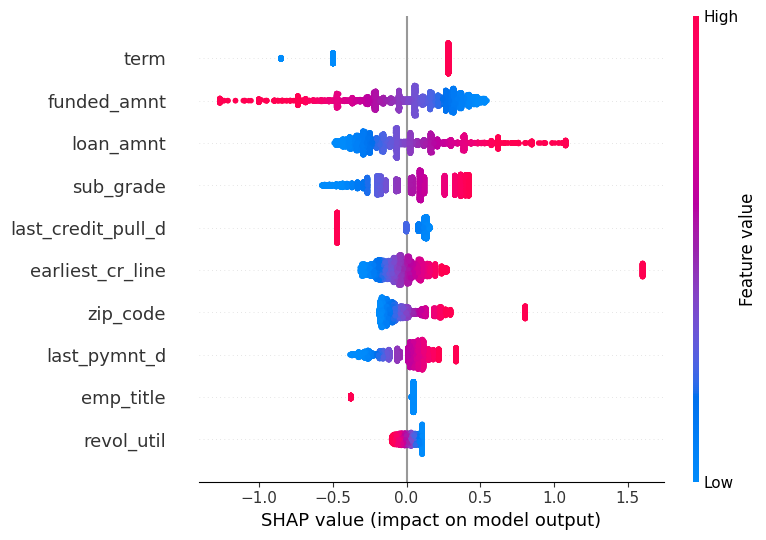

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [90]:
plt.clf()
# SHAP values for Decision Tree
# explainer_dt = shap.LinearExplainer(logistic_model,
#                                   data = X_val_selected_dict['logistic'])
explainer_lr = shap.LinearExplainer(logistic_model,
                                    masker=shap.maskers.Independent(X_val_selected_dict['logistic']))

shap_values_lr = explainer_lr.shap_values(X_val_selected_dict['logistic'])

shap.summary_plot(shap_values_lr[:,:],
                  X_val_selected_dict['logistic'],
                  max_display = 10)

plt.show()
display(plt.gcf())

Dựa vào "term", đây là feature có ảnh hưởng nhất đối với logistic model, chúng phản ánh việc các hồ sơ vay nếu có thời hạn dài hơn (36 tháng) thì thường có tỉ lệ được chấp nhận vay (loan approval) cao hơn so với các khoản vay ngắn hạn.

Dựa vào biểu đồ, ta thấy rằng hai tiêu chí "funded_amnt" và "loan_amnt" có ảnh hưởng tương đối đến việc loan rejection và loan approval. Nếu như "funded_amnt" càng lớn, tức người vay có nhu cầu tài chính cao hơn đi kèm với nhiều rủi ro hơn, thường có xu hướng dẫn đến loan rejected, còn ngược lại, với giá trị SHAP của loan_amnt có thể cho thấy rằng các khoản vay với số tiền yêu cầu cao hơn có thể được xem là hợp lý và có khả năng được chấp nhận. Điều này có thể giải thích tại sao giá trị SHAP của loan_amnt có thể dương và cao. Ngoài ra thì
Sub Grade (sub_grade): Phân loại phụ của khoản vay do LC gán - giá trị cao hơn có thể cho thấy người vay có hồ sơ tín dụng tốt hơn.

Ngoài ra các tiêu chí như (last_credit_pull_d), (earliest_cr_line), (zip_code), (last_pymnt_d), (emp_title), (revol_util) cũng cố các thông tin về củng cố liên quan đến người vay :      

1. Last Credit Pull Date (last_credit_pull_d): Tháng gần nhất mà LC kiểm tra tín dụng của khoản vay này. Thông tin này có thể cho thấy tình trạng tài chính hiện tại của người vay.

2. Earliest Credit Line (earliest_cr_line): Tháng mà dòng tín dụng đầu tiên của người vay được mở. Giá trị cao hơn có thể cho thấy người vay có lịch sử tín dụng lâu dài hơn.

3. Zip Code (zip_code): Mã bưu điện của người vay. Thông tin này có thể được sử dụng để đánh giá rủi ro dựa trên vị trí địa lý.

4. Last Payment Date (last_pymnt_d): Tháng gần nhất mà khoản thanh toán đã được nhận. Thông tin này có thể cho thấy người vay có thực hiện thanh toán đúng hạn hay không.

5. Employment Title (emp_title): Chức danh công việc của người vay. Thông tin này có thể cho thấy mức độ ổn định trong công việc của người vay.

6. Revolving Utilization (revol_util): Tỷ lệ sử dụng tín dụng quay vòng. Giá trị cao hơn có thể cho thấy người vay đang sử dụng nhiều tín dụng hơn so với hạn mức tín dụng của họ.

In [1]:
1

1

In [104]:
type(X_val_selected_dict['neural network'])

torch.Tensor

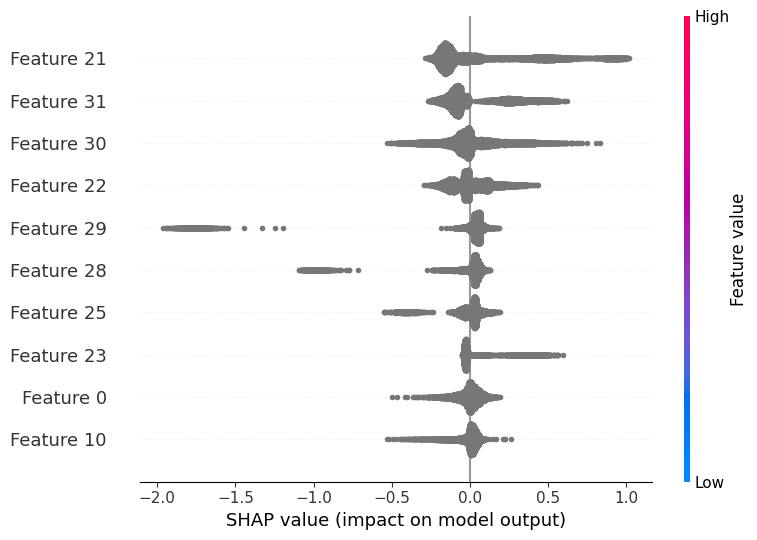

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [110]:
plt.clf()
model.eval()
# SHAP values for Decision Tree
X_val_tripped = shap.sample(X_val_selected_dict['neural network'],1000)
explainer_nn = shap.DeepExplainer(neural_network_model,
                                  data = shap.sample(X_val_tripped ,1000))

shap_values_nn = explainer_nn.shap_values(X_val_selected_dict["neural network"])



In [1]:
shap.summary_plot(shap_values_nn[:,:,0],
                  X_val_selected_dict["neural network"],
                  max_display = 10)

plt.show()
display(plt.gcf())

NameError: name 'shap' is not defined

In [111]:
shap.initjs()

Local interpretability

In [ ]:
random_idx = np.random.randint(len(X_train))
random_idx

In [ ]:
shap.waterfall_plot(shap_explainer_values[random_idx])

In [ ]:
shap.force_plot(shap_explainer_values[random_idx])